## Import Libraries

In [1]:
import cv2 as cv 
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

%matplotlib inline

## Helper functions
**_Show Image Helper Function_** This helper function is used to plot the image , with a given title has a default value of **_"Image"_** , we also pass to the function color map argument that it has default value of **_gray_**


In [2]:
def show_image(image , title = "Image" , color_map = "gray") :
    plt.imshow(image , cmap= color_map)
    plt.title(title)
    plt.show

**_Region Of Interest Helper Functions_**
We will crop part of the photo where we are have more interest in this region to determine the lane lines , the steps are the following we make a black image with all zeros , then we have the vertices of ploy to draw on the black image , then making masking using python function `cv.bitwise_and()`

In [3]:
def region_of_intereset(image , vertices):
    blank = np.zeros_like(image)
    cv.fillPoly(blank , vertices , color = 255)
    cropped_region = cv.bitwise_and(image , blank)
    return cropped_region

**_Fill Area Between Lane Lines Helper Function_** we here after detecting the lane lines we just color the area between them , by passing to the funtion the 4 vertices of the two lane lines

In [4]:
def fill_area_between_lane_lines(image , polyfill_vertices):
    point1 = ()
    point2 = ()
    point3 = ()
    point4 = ()
    for i in range(0 , 4) :
        x1 , y1 = polyfill_vertices[i]
        if(i == 0):
            point1 = (x1 , y1)
            continue
        elif(i == 1):
            point2 = (x1 , y1)
            continue
        elif(i == 2):
            point3 = (x1, y1)
            continue
        elif(i == 3):
            point4 = (x1, y1)
            continue
    polyfill_vertices_in_right_order = [point1 , point2 , point4 , point3]
    cv.fillPoly(image , np.array([polyfill_vertices_in_right_order] , np.int64) , (92, 255, 92))

**_Three Channel Image Conversion Helper Function_** here we take image of signle channel and convert it to 3 channels in the purpose of concatenate it with other images in the debugging mode

In [5]:
def three_channle_image_conversion(source_image , converted_image):
    blank_image = np.zeros_like(source_image)
    blank_image[:,:,0] = converted_image
    blank_image[:,:,1] = converted_image
    blank_image[:,:,2] = converted_image
    return blank_image

**_Debuggind Mode Image Hepler Function_** we here concatenate all the image stages that it has passed through in the pipeline in one image

> This function is activated only when Debugging Mode is set **_Activated_**

In [6]:
def debugging_mode_image(test_image , gray_test_image , RGB_test_image , hls_test_image , s , canny_test_image , cropped_test_image):
    v_image1 = np.vstack([cv.resize(test_image , (320 , 320)) , cv.resize(three_channle_image_conversion(test_image , gray_test_image) , (320 , 320))])
    h_image1 = np.hstack([cv.resize(RGB_test_image , (960 , 400)) , cv.resize(v_image1, (320 , 400))])
    h_image2 = np.hstack([cv.resize(hls_test_image , (320 , 320)) , cv.resize(three_channle_image_conversion(test_image , s) , (320 , 320))])
    h_image3 = np.hstack([cv.resize(three_channle_image_conversion(test_image , canny_test_image) , (320 , 320)) , cv.resize(three_channle_image_conversion(test_image , cropped_test_image) , (320 , 320))])
    h_image4 = np.hstack([cv.resize(h_image2 , (640 , 320)) , cv.resize(h_image3 , (640 , 320))])
    debugging_image = np.vstack([cv.resize(h_image1 , (1280 , 400)) , cv.resize(h_image4 , (1280 , 320))])
    return debugging_image

**_Yolo Helper Function_** this is the yolo algorithm is used to detect cars on the roads, this algorithms uses neural networks, its version is **YOLOv3-416**

In [7]:
def yolo(image):
    weights_path = os.path.join ("yolov3.weights")
    config_path = os.path.join ("yolov3.cfg")
    labels_path = os.path.join("coco.names")
    net = cv.dnn.readNetFromDarknet(config_path , weights_path)
    names = net.getLayerNames()
    layers_names = [names[i - 1] for i in net.getUnconnectedOutLayers()]
    (H,W)= image.shape[:2]
    blob = cv.dnn.blobFromImage (image, 1/255.0 , (416,416), crop=False,swapRB=False)
    net.setInput(blob)
    layers_output=net.forward(layers_names)
    boxes =[]
    confidences=[]
    classIDs=[]
    for output in layers_output:
        for detection in output:
            scores=detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.85:
                box = detection[:4]*np.array([W,H,W,H])
                bx, by, bw, bh = box.astype("int")
                x=int(bx - (bw/2))
                y=int(by - (bh/2))
                boxes.append([x,y,int(bw),int(bh)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv.dnn.NMSBoxes(boxes,confidences,0.8,0.8)
    if len(idxs) == 0:
        return image
    else:
        labels = open(labels_path).read().strip().split("\n")
        for i in idxs.flatten():
            (x,y) = [boxes[i][0],boxes[i][1]]
            (w,h)=[boxes[i][2],boxes[i][3]]
            cv.rectangle(image, (x,y),(x+w,y+h),(255,0,0),2)
            cv.putText (image,"{}:{}".format(labels[classIDs[i]],confidences[i]),(x,y-5),cv.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2)
        return image

**_Make Coordinates Helper Function_**

In [ ]:
def make_coordinates (image, line_parameters):
    try:
        slope, intercept = line_parameters
    except TypeError:
        slope, intercept = 0.001, 0
    #slope, intercept = line_parameters
    height= image.shape[0]
    y1=height
    y2=int(y1*(0.65))
    x1=int((y1-intercept)/slope)
    x2=int((y2-intercept)/slope)
    
    return np.array([x1,y1,x2,y2])

**_Average Slope Intercept Helper Functions_**

In [ ]:
def average_slope_intercept(image,lines):
    left_fit=[]
    right_fit=[]
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2=line.reshape(4)
            parameters=np.polyfit((x1,x2),(y1,y2),1)
            slope=parameters[0]
            intercept=parameters[1]
            if slope<0:
                left_fit.append((slope,intercept))
            else:
                right_fit.append((slope,intercept))
    left_fit_average=np.average(left_fit,axis=0)     
    right_fit_average=np.average(right_fit,axis=0)
    left_line= make_coordinates(image,left_fit_average)
    right_line= make_coordinates(image,right_fit_average)
    
    return np.array([left_line, right_line])

**_Display Lines Helper Function_**

In [ ]:
def display_lines(image, lines):
    line_image= np.zeros_like(image)
    if lines is not None :
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
#             print (x1, ' ', y1, ' ', x2, ' ', y2) ################3
            cv.line(line_image,(int(x1),int(y1)),(int(x2),int(y2)),(0,0,255),4)     # cv.line(line_image,(x1,y1),(x2,y2),(0,0,255),4)
            #            cv.line(line_image,(x1.astype(np.int64),y1.astype(np.int64)),(x2.astype(np.int64),y2.astype(np.int64)),(0,0,255),4)     # cv.line(line_image,(x1,y1),(x2,y2),(0,0,255),4)
    return line_image

### Offset of the car
`compute_offset(image, lines)`: is used to get the offset and direction of the car. The car center is in the middle of the image. the lane center is calculated using starting points of the lane in the x-axis corresbonding to the height of the image in the y-axis.

In [ ]:
def compute_offset(image, lines):
    x=[]
    line_image= np.zeros_like(image)
    car_center = image.shape[1] / 2
    if lines is not None :
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
            x.append(x1)
    lane_center = (x[0] + x[1]) / 2  
    offset = abs(lane_center - car_center) * (3.7/700)
    if (x[0] > (1280 - x[1])):
        direction = 'left'
    elif (x[0] < (1280 - x[1])):
        direction = 'right'
    else:
        direction = 'center'
    return offset,direction

### Read the test image

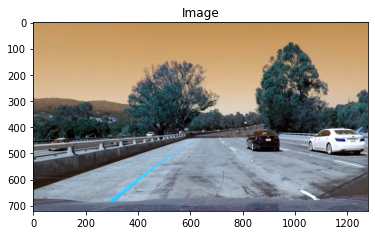

In [8]:
test_image = cv.imread("test_images/test1.jpg")
show_image(test_image)
debug_mode = 0

### Change the color space 
we here change the color space of the image from BGR to RGB to show the real color space of the image

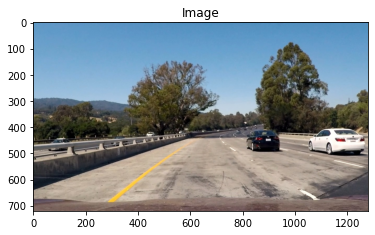

In [9]:
RGB_test_image = cv.cvtColor(test_image , cv.COLOR_BGR2RGB)
show_image(RGB_test_image)

### Image Dimensions

In [10]:
print("Image Shape" , RGB_test_image.shape)
image_width = RGB_test_image.shape[1]
image_height = RGB_test_image.shape[0]
print("Image width" , image_width)
print("Image height" , image_height)

Image Shape (720, 1280, 3)
Image width 1280
Image height 720


### Change the color space 
we here change the color space of the image from RGB to grayscale

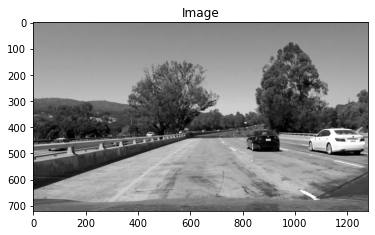

In [11]:
gray_test_image = cv.cvtColor(RGB_test_image , cv.COLOR_RGB2GRAY)
show_image(gray_test_image)

### Change color space
we here change the color space of the image from **_RGB_** into **_HLS_** color space as this color space would be very useful when we deal with image that has sunlight (part of it or whole of it), and that would make a very high noise and a cause of that that we will not determine any more the lane lines

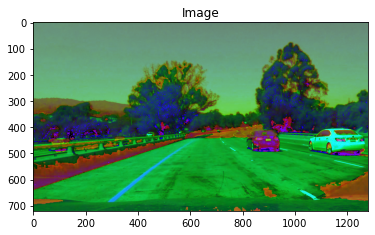

In [12]:
hls_test_image = cv.cvtColor(RGB_test_image , cv.COLOR_RGB2HLS)
show_image(hls_test_image)

### Split HLS into Channels
we here divide the HLS image into three channels as we desire to deal with S channel as it provide clear lane lines among the other channels

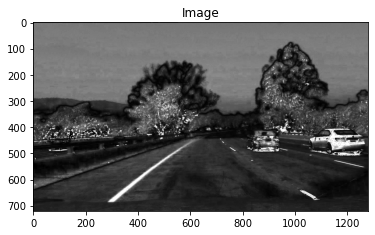

In [13]:
h , l , s = cv.split(hls_test_image)
show_image(s)

### Blurring 
we will blurring to the image to just reduce some details and make smoothing to the photo to be able to be concentrated on the lane lines only , we will use `cv.GaussianBlur()`

In [14]:
blurred_test_image = cv.GaussianBlur(s , (5,5) , 0)

### Edge Detection
We will use **_Canny edge_** detection 

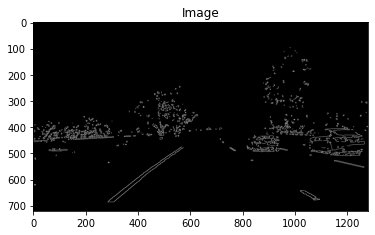

In [15]:
canny_test_image = cv.Canny(blurred_test_image , 200 ,255)
show_image(canny_test_image)

## Region Of Intereset

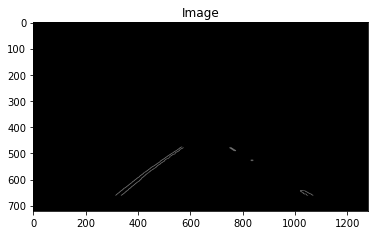

In [16]:
vertices_of_region_of_interest = [(100 , 660) , (image_width / 2 , image_height / 2 + 65) , (1200 , 660)]
cropped_test_image = region_of_intereset(canny_test_image , np.array([vertices_of_region_of_interest] , np.int64))
show_image(cropped_test_image)

### Hough Transform & Optimization
In this section we use Hough transform to find lane lines then averaging the lines to have 2 smooth lines contouring the lane.
`display_lines(image,lines)`: used to draw lines on the image
`average_slope_intercept(image,lines)`: used to get the average of the left_lines from hough transform as a single left_line and to get the average of the right_lines from hough transform as a single right line as well.
`make_coordinates(image,line_parameters)`: used to get points on the line to be able to draw it.
#### Steps:
1. get hough lines.
2. calculate the average of hough lines on the left and right to get a single line on the left and on the right.
3. display these lines on the image.

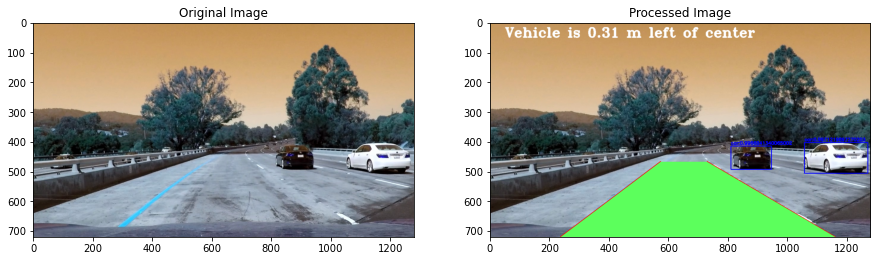

In [21]:
hough_lines = cv.HoughLinesP(cropped_test_image , 1, np.pi / 180 , 20, minLineLength = 7 , maxLineGap = 1)
averaged_lines=average_slope_intercept(RGB_test_image,hough_lines)
line_image=display_lines(RGB_test_image,averaged_lines)
offset,direction=compute_offset(RGB_test_image,averaged_lines)
polyfill_vertices = []
if averaged_lines is not None:
        for line in averaged_lines :
            x1 ,y1 ,x2 ,y2 = line.reshape(4)
            cv.line(RGB_test_image , (x1.astype(np.int64) , y1.astype(np.int64)) , (x2.astype(np.int64) ,y2.astype(np.int64)) , (0 , 0 , 255) , thickness = 4)
            polyfill_vertices.append((x2,y2))
            polyfill_vertices.append((x1,y1))
fill_area_between_lane_lines(RGB_test_image , polyfill_vertices)
if debug_mode == 0 :
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(1,2,1)
    show_image(test_image, 'Original Image')
    fig.add_subplot(1,2,2)
    cv.putText(img=RGB_test_image, text="Vehicle is {0:.2f} m {1} of center".format(offset, direction), org=(50, 50), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=1.5, color=(255, 255, 255),thickness=3)
    show_image(cv.cvtColor(yolo(RGB_test_image) , cv.COLOR_RGB2BGR) , 'Processed Image')
elif debug_mode == 1 :
    plt.figure(figsize=(20, 12))
    debugging_image = debugging_mode_image(test_image , gray_test_image , cv.cvtColor(RGB_test_image , cv.COLOR_RGB2BGR) , hls_test_image , s , canny_test_image , cropped_test_image)
    cv.putText(img=debugging_image, text="Vehicle is {0:.2f} m {1} of center".format(offset, direction), org=(50, 50), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=1.5, color=(255, 255, 255),thickness=3)
    show_image(debugging_image , "Debugging Mode")

### Processing on video frames
We define a function that performs all the previous operations on a given input image to be applied on video frames.

In [22]:
def frame_process(test_image , debug_mode):
    RGB_test_image = np.copy(test_image)
    gray_test_image = cv.cvtColor(RGB_test_image , cv.COLOR_RGB2GRAY)
    image_width = RGB_test_image.shape[1]
    image_height = RGB_test_image.shape[0]
    hls_test_image = cv.cvtColor(RGB_test_image , cv.COLOR_RGB2HLS)
    h , l , s = cv.split(hls_test_image)
    ret,thresh1 = cv.threshold(gray_test_image,120, 255,  cv.THRESH_BINARY+cv.THRESH_OTSU)
    combined = cv.addWeighted(thresh1,0.3,s, 0.7,0)
    blurred_test_image = cv.GaussianBlur(combined , (5,5) , 0)
    canny_test_image = cv.Canny(blurred_test_image , 70 , 255)
    vertices_of_region_of_interest = [(100 , 660) , (image_width / 2 , image_height / 2 + 65) , (1200 , 660)]
    cropped_test_image = region_of_intereset(canny_test_image , np.array([vertices_of_region_of_interest] , np.int64))
    hough_lines = cv.HoughLinesP(cropped_test_image , 1 , np.pi / 180 , 20 , minLineLength = 2 , maxLineGap = 50)
    polyfill_vertices = []
    averaged_lines=average_slope_intercept(RGB_test_image,hough_lines)
    line_image=display_lines(RGB_test_image,averaged_lines)
    offset,direction=compute_offset(RGB_test_image,averaged_lines)
    if averaged_lines is not None:
        for line in averaged_lines :
            x1 ,y1 ,x2 ,y2 = line.reshape(4)
            cv.line(RGB_test_image , (int(x1) , int(y1)) , (int(x2) ,int(y2)) , (0 , 0 , 255) , thickness = 4)
            #            cv.line(RGB_test_image , (x1.astype(np.int64) , y1.astype(np.int64)) , (x2.astype(np.int64) ,y2.astype(np.int64)) , (0 , 0 , 255) , thickness = 4)
            polyfill_vertices.append((x2,y2))
            polyfill_vertices.append((x1,y1))
    fill_area_between_lane_lines(RGB_test_image , polyfill_vertices)
    debugging_image = debugging_mode_image(test_image , gray_test_image , RGB_test_image , hls_test_image , s , canny_test_image , cropped_test_image)
    if debug_mode == 0 :
        cv.putText(img=RGB_test_image, text="Vehicle is {0:.2f} m {1} of center".format(offset, direction), org=(50, 50), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=1.5, color=(255, 255, 255),thickness=3)
        return yolo(RGB_test_image)
    elif debug_mode == 1:
        cv.putText(img=debugging_image, text="Vehicle is {0:.2f} m {1} of center".format(offset, direction), org=(50, 50), fontFace=cv.FONT_HERSHEY_TRIPLEX, fontScale=1.5, color=(255, 255, 255),thickness=3)
        return debugging_image

### Testing on video

**_Without Debug Mode_**

In [ ]:
cap = cv.VideoCapture("project_video.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    if frame is None:
        print('Frame not successfully read')
        break
    processed_frame = frame_process(frame, 0)
    cv.imshow("result", processed_frame)
    if cv.waitKey(1)  == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

**_With Debug Mode_**

In [ ]:
cap = cv.VideoCapture("harder_challenge_video.mp4")
while(cap.isOpened()):
    _, frame = cap.read()
    if frame is None:
        break
    processed_frame = frame_process(frame, 1)
    cv.imshow("result", processed_frame)
    if cv.waitKey(1)  == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

| **Name** | **ID** |
| --- | --- |
| Shereen Reda Sayed Mohamed | 1804990 |
| Mahmoud Khaled Abdelaal Aly | 1801004 |
| Maram Nabil Ibrahim Ali | 1803746 |
